# Rank selection (outcome)

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan 10 13:35:33 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# Import google drive mounting module
from google.colab import drive

# Import os/path lib to navigate the colab directory.
import os
import pathlib


# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/OPM-MEG'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/OPM-MEG


In [4]:
!git clone https://github.com/hug0-w/Tensor-Decompositions-OPM-MEG/
!pip install tensorly

Cloning into 'Tensor-Decompositions-OPM-MEG'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 81 (delta 19), reused 74 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 110.95 KiB | 2.05 MiB/s, done.
Resolving deltas: 100% (19/19), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 66.9 MB/s eta 0:00:00


In [5]:
mat_path = "outcome_pow_trial_chan_fbin_time_ds500_tpos.mat"

with h5py.File(mat_path, "r") as f:

    # --- main data ---
    # HDF5 reads MATLAB v7.3 arrays with transposed dimensions.
    # MATLAB Saved: [Trials, Chan, Freqs, Time]
    # Python Reads: (Time, Freqs, Chan, Trials)
    Pow = np.array(f["Pow"])

    freq = np.array(f["freq"]).squeeze()
    time = np.array(f["time"]).squeeze()

    # Removed: fbins = np.array(f["fbins"])
    freqs_hz = np.array(f["freqs_hz"]).squeeze()

    ds_fs = float(np.array(f["ds_fs"]).squeeze())
    fs_orig = float(np.array(f["fs_orig"]).squeeze())

    # --- channel labels (MATLAB cellstr) ---
    # MATLAB cell arrays of strings are stored as object references in HDF5
    ch_names_refs = f["chan_lbl"][()]
    chan_lbl = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        # MATLAB v7.3 stores strings as uint16 (utf-16le)
        chan_lbl.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    # --- MNE metadata ---
    mne_grp = f["mne"]

    ch_names_refs = mne_grp["ch_names"][()]
    mne_ch_names = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        mne_ch_names.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    ch_pos_m = np.array(mne_grp["ch_pos_m"], dtype=float)
    # MATLAB stored (N, 3), HDF5 reads (3, N). Transpose to get (N_chan, 3).
    if ch_pos_m.shape[0] == 3 and ch_pos_m.shape[1] != 3:
        ch_pos_m = ch_pos_m.T

    # Decode coordinate frame string (e.g., 'head')
    coord_frame_data = mne_grp["coord_frame"][()]
    try:
        coord_frame = coord_frame_data.tobytes().decode("utf-16le").rstrip("\x00")
    except AttributeError:
        # Fallback if it loaded as a simple byte string or char
        coord_frame = str(coord_frame_data)

In [7]:
Pow.shape

(751, 35, 121, 195)

In [8]:
Pow_nn = np.log1p(Pow)

In [9]:
trial_scale = Pow_nn.mean(axis=(1,2,3), keepdims=True)

Pow_nn = Pow_nn / trial_scale

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
log_Pow_torch = torch.as_tensor(Pow_nn, device=device, dtype=torch.float32)

In [11]:
%cd Tensor-Decompositions-OPM-MEG/
from src.tools.stability import similarity_matrix, rank_stability, optimal_score, stability_plot

/content/drive/MyDrive/OPM-MEG/Tensor-Decompositions-OPM-MEG


In [13]:
import tensorly as tl
tl.set_backend('pytorch')

In [14]:
from tqdm import tqdm

In [16]:
ranks = np.arange(1,21,1)

stabilities = []
stds = []

for i in tqdm(ranks):

    stability,std = rank_stability(log_Pow_torch,i,n_repeats=10)


    stabilities.append(stability)
    stds.append(std)

100%|██████████| 20/20 [38:35<00:00, 115.79s/it]


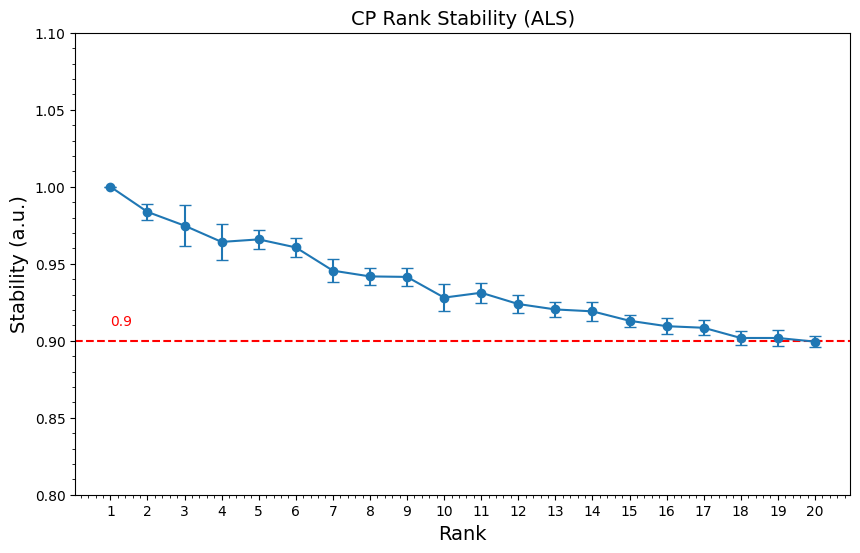

In [22]:
stability_plot(ranks,stabilities,stds)
plt.ylim(0.8,1.1)
plt.grid(False)

In [23]:
ranks_v2 = np.arange(1,26,1)

stabilities_v2 = []
stds_v2 = []

for i in tqdm(ranks_v2):

    stability,std = rank_stability(log_Pow_torch,i,n_repeats=15)


    stabilities_v2.append(stability)
    stds_v2.append(std)

100%|██████████| 25/25 [1:18:13<00:00, 187.75s/it]


Text(0.5, 1.0, 'CP Rank Stability (ALS) - Outcome')

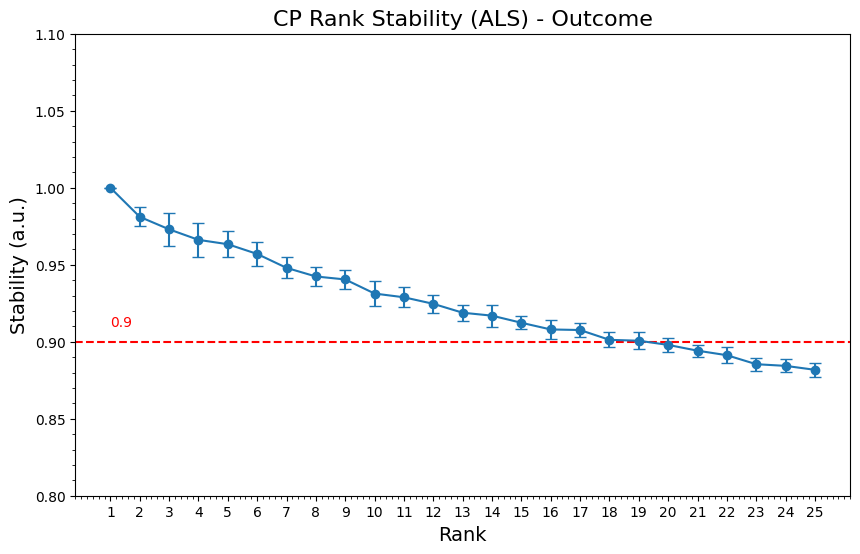

In [29]:
stability_plot(ranks_v2,stabilities_v2,stds_v2)
plt.ylim(0.8,1.1)
plt.grid(False)
plt.title('CP Rank Stability (ALS) - Outcome',fontsize=16)